In [214]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [215]:
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    precision_score, 
    recall_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [216]:
df = pd.read_csv("../../our_analyses/dataset_prepared.csv")

In [217]:
df.head()

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,n_beats,genre
0,Love Came Down,293106,False,50,Kari Jobe,Where I Find You,0.401,0.683,8,-5.722,1,0.0401,0.181,0.000000,0.0837,0.226,135.951,4.0,654.0,afrobeat
1,PIMP,194972,False,52,Bacao Rhythm & Steel Band,55,0.672,0.858,3,-5.233,1,0.1450,0.456,0.811000,0.1040,0.963,166.689,4.0,537.0,afrobeat
2,Soul Saxes Meeting,178428,False,22,Manu Dibango,African Voodoo,0.636,0.826,3,-7.486,1,0.0585,0.461,0.271000,0.1410,0.731,102.809,4.0,304.0,afrobeat
3,Reino Animal,238373,False,20,Los Amigos Invisibles,Repeat After Me,0.733,0.862,7,-5.813,1,0.0604,0.287,0.000532,0.4660,0.745,107.981,4.0,427.0,afrobeat
4,La luna de espejos,221893,False,22,Jorge Drexler,Sus primeras grabaciones 1992-1994 (La luz que...,0.712,0.225,5,-10.017,1,0.0533,0.930,0.001000,0.1230,0.429,87.520,4.0,317.0,afrobeat


In [218]:
df["genre"].unique()

array(['afrobeat', 'black-metal', 'bluegrass', 'brazil', 'breakbeat',
       'chicago-house', 'disney', 'forro', 'happy', 'idm', 'indian',
       'industrial', 'iranian', 'j-dance', 'j-idol', 'mandopop', 'sleep',
       'spanish', 'study', 'techno'], dtype=object)

In [219]:
def apply_pattern_rules(df):
    """
    Apply the pattern rules to the DataFrame and filter out rows that do not conform to these rules.
    """
    # World/Commercial Pop
    df_wc_pop = df[(df['genre_group'] == 3) & 
                   (df['danceability'] > 0.695) & (df['danceability'] <= 0.98) & 
                   (df['energy'] > 0.709) & (df['energy'] <= 0.884)]

    # Electronic/Dance
    df_electronic_dance_1 = df[(df['genre_group'] == 0) & 
                               (df['valence'] > -0.001) & (df['valence'] <= 0.196) & 
                               (df['popularity'] > -0.001) & (df['popularity'] <= 14.0)]
    df_electronic_dance_2 = df[(df['genre_group'] == 0) & 
                               (df['loudness'] > -49.532) & (df['loudness'] <= -10.636) & 
                               (df['popularity'] > -0.001) & (df['popularity'] <= 14.0)]

    # Other
    df_other_1 = df[(df['genre_group'] == 4) & 
                    (df['energy'] > -0.001) & (df['energy'] <= 0.48) & 
                    (df['acousticness'] > 0.573) & (df['acousticness'] <= 0.996) & 
                    (df['loudness'] > -49.532) & (df['loudness'] <= -10.636)]
    df_other_2 = df[(df['genre_group'] == 4) & 
                    (df['acousticness'] > 0.573) & (df['acousticness'] <= 0.996) & 
                    (df['energy'] > -0.001) & (df['energy'] <= 0.48)]

    # Country/Folk/Pop
    df_country_folk_pop_1 = df[(df['genre_group'] == 2) & 
                               (df['energy'] > 0.884) & (df['energy'] <= 1.0) & 
                               (df['loudness'] > -5.101) & (df['loudness'] <= 3.156) & 
                               (df['instrumentalness'] > -0.001) & (df['instrumentalness'] <= 0.00313)]
    df_country_folk_pop_2 = df[(df['genre_group'] == 2) & 
                               (df['loudness'] > -5.101) & (df['loudness'] <= 3.156) & 
                               (df['energy'] > 0.884) & (df['energy'] <= 1.0)]

    # Metal/Rock
    df_metal_rock_1 = df[(df['genre_group'] == 1) & 
                         (df['popularity'] > 14.0) & (df['popularity'] <= 24.0) & 
                         (df['acousticness'] > -0.001) & (df['acousticness'] <= 0.00974)]
    df_metal_rock_2 = df[(df['genre_group'] == 1) & 
                         (df['energy'] > 0.884) & (df['energy'] <= 1.0) & 
                         (df['acousticness'] > -0.001) & (df['acousticness'] <= 0.00974)]

    # Combine all filtered DataFrames
    df_filtered = pd.concat([df_wc_pop, df_electronic_dance_1, df_electronic_dance_2, 
                             df_other_1, df_other_2, df_country_folk_pop_1, 
                             df_country_folk_pop_2, df_metal_rock_1, df_metal_rock_2])

    return df_filtered
from sklearn.preprocessing import LabelEncoder, StandardScaler


df = df.drop(['name', 'artists', 'album_name'], axis=1)

genre_groups = {
    'idm': 0, 'iranian': 0, 'study': 0,  # Electronic/Dance
    'black-metal': 1, 'breakbeat': 1, 'techno': 1,  # Metal/Rock
    'brazil': 2, 'forro': 2, 'happy': 2, 'spanish': 2, 'j-idol': 2,  # Country/Folk/Pop
    'afrobeat': 3, 'chicago-house': 3, 'industrial': 3, 'j-dance': 3,  # World/Commercial Pop
    'bluegrass': 4, 'disney': 4, 'indian': 4, 'mandopop': 4, 'sleep': 4  # Other
}

df['genre_group'] = df['genre'].map(genre_groups).astype(int)

le = LabelEncoder()
df['explicit'] = le.fit_transform(df['explicit'])

# Apply the pattern rules to the datasets
df= apply_pattern_rules(df)

df.head()

,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,n_beats,genre,genre_group
3,238373,0,20,0.733,0.862,7,-5.813,1,0.0604,0.2870,0.000532,0.4660,0.745,107.981,4.0,427.0,afrobeat,3
7,347772,0,18,0.774,0.719,10,-8.976,0,0.0486,0.0181,0.128000,0.0781,0.890,132.025,4.0,763.0,afrobeat,3
8,219746,0,31,0.762,0.858,9,-4.589,0,0.0313,0.3210,0.062900,0.2760,0.836,126.005,4.0,458.0,afrobeat,3
17,257693,1,20,0.759,0.780,0,-8.007,1,0.0385,0.0024,0.050600,0.3210,0.510,125.050,4.0,530.0,afrobeat,3
26,175856,0,20,0.787,0.726,7,-5.637,1,0.1640,0.0719,0.003130,0.0870,0.407,107.024,4.0,303.0,afrobeat,3


In [220]:
df.head()

,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,n_beats,genre,genre_group
3,238373,0,20,0.733,0.862,7,-5.813,1,0.0604,0.2870,0.000532,0.4660,0.745,107.981,4.0,427.0,afrobeat,3
7,347772,0,18,0.774,0.719,10,-8.976,0,0.0486,0.0181,0.128000,0.0781,0.890,132.025,4.0,763.0,afrobeat,3
8,219746,0,31,0.762,0.858,9,-4.589,0,0.0313,0.3210,0.062900,0.2760,0.836,126.005,4.0,458.0,afrobeat,3
17,257693,1,20,0.759,0.780,0,-8.007,1,0.0385,0.0024,0.050600,0.3210,0.510,125.050,4.0,530.0,afrobeat,3
26,175856,0,20,0.787,0.726,7,-5.637,1,0.1640,0.0719,0.003130,0.0870,0.407,107.024,4.0,303.0,afrobeat,3


In [221]:
# Definizione di y come l'array delle etichette dei generi
y = np.array(df['genre_group'])

# Rimozione delle colonne 'genre_group' e 'genre' per ottenere le feature
X = df.drop(['genre_group', 'genre', 'mode'], axis=1)


## Partitioning

In [222]:
from sklearn.model_selection import train_test_split

random_state = 0

In [223]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=random_state
)

print(np.unique(y, return_counts=True)[1] / len(y))
print(np.unique(y_train, return_counts=True)[1] / len(y_train))
print(np.unique(y_test, return_counts=True)[1] / len(y_test), ("\n"))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

[0.19593254 0.18427579 0.22594246 0.06262401 0.3312252 ]
[0.19596031 0.18426648 0.22590361 0.06272147 0.33114812]
[0.19586777 0.18429752 0.22603306 0.06239669 0.33140496] 

(5644, 15) (2420, 15) (5644,) (2420,)


## normalization

In [224]:
from sklearn.preprocessing import StandardScaler

In [225]:
norm = StandardScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

## K-NN

In [226]:
from sklearn.neighbors import KNeighborsClassifier

In [227]:
clf = KNeighborsClassifier(n_neighbors=13, metric="cityblock", weights="distance")
clf.fit(X_train_norm, y_train)

KNeighborsClassifier(metric='cityblock', n_neighbors=13, weights='distance')

In [228]:
dt_train_acc = clf.score(X_train_norm, y_train)
dt_test_acc = clf.score(X_test_norm, y_test)
print(f'Decision Tree train accuracy: {dt_train_acc}')
print(f'Decision Tree test accuracy: {dt_test_acc}')

Decision Tree train accuracy: 1.0
Decision Tree test accuracy: 0.9086776859504132


In [229]:
y_test_pred = clf.predict(X_test_norm)
y_test_pred
y_test_pred_proba = clf.predict_proba(X_test_norm) 
y_test_pred_proba[0:10]

array([[0.        , 0.        , 0.06938534, 0.93061466, 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.91713743, 0.        , 0.08286257, 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ]])

In [230]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Assumiamo che 'y_test' e 'y_test_pred' siano già definiti e contengano le etichette vere e predette dal tuo modello

# Genera la matrice di confusione
cf = confusion_matrix(y_test, y_test_pred)

# Definisci le etichette per i generi in base ai raggruppamenti definiti
genre_labels = [' Electronic/Dance', 'Metal/Rock', 'Country/Folk/Pop', 'World/Commercial Pop', 'Other']

# Crea la heatmap usando plotly
fig = ff.create_annotated_heatmap(z=cf, x=genre_labels, y=genre_labels,
                                  annotation_text=cf.astype(str), colorscale='Greens')

# Aggiorna il layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.02,
                  xaxis=dict(title='Predicted Labels', tickangle=45),
                  yaxis=dict(title='True Labels', tickmode='array', tickvals=list(range(len(genre_labels))), ticktext=genre_labels),
                  yaxis_autorange='reversed')  # Reverse the y-axis to have the first class at the top

# Mostra il grafico
fig.show()



In [231]:
import plotly.graph_objects as go
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# Binarizza le etichette in un formato one-vs-rest e calcola i punteggi di probabilità per le classi
Y = label_binarize(y_test, classes=np.unique(y_test))
y_scores = clf.predict_proba(X_test_norm)

# Inizializza dizionari per precision e recall
precision = dict()
recall = dict()
average_precision = dict()

# Calcola precision e recall per ogni classe
for i in range(len(np.unique(y_test))):
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(Y[:, i], y_scores[:, i])

# Crea un grafico Plotly
fig = go.Figure()

# Aggiunge una linea per ogni classe
for i, genre in enumerate(np.unique(y_test)):
    fig.add_trace(go.Scatter(x=recall[i], y=precision[i], mode='lines', name=f'Class {i} (AP={average_precision[i]:0.2f})'))

# Aggiorna il layout
fig.update_layout(
    title="Precision-Recall curve",
    xaxis_title="Recall",
     width=1000,  # Larghezza del plot
    height=800,  
    yaxis_title="Precision",
    legend_title="Classes"
)

# Mostra il grafico
fig.show()


In [232]:
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go

# Calcola ROC curve e AUC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Crea un grafico Plotly
fig = go.Figure()

# Aggiunge una linea per ogni classe
for i, genre in enumerate(np.unique(y_test)):
    fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', name=f'Class {i} (AUC={roc_auc[i]:0.2f})'))

# Aggiunge la linea diagonale per il random guessing
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Guessing', line=dict(dash='dash')))

# Aggiorna il layout
fig.update_layout(
    title="ROC curve per classe",
    xaxis_title="False Positive Rate",
     width=1000,  # Larghezza del plot
    height=800,  
    yaxis_title="True Positive Rate",
    legend_title="Classes"
)

# Mostra il grafico
fig.show()


In [233]:
clf.score(X_test_norm, y_test)

0.9086776859504132

In [234]:
(y_test_pred == y_test).sum() / len(y_test)

0.9086776859504132

In [235]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.9086776859504132


In [236]:
from sklearn.model_selection import learning_curve

In [237]:
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"), "\n")
print("F1 micro:", f1_score(y_test, y_test_pred, average="micro"), "\n")
unique_labels = np.unique(y_test)

for label in unique_labels:
    print(f"F1 macro for label {label}:", f1_score(y_test, y_test_pred, labels=[label], average="macro"))
print("\n")
for label in unique_labels:
    print(f"F1 micro for label {label}:", f1_score(y_test, y_test_pred, labels=[label], average="micro"))

F1 macro: 0.8810100766173198 

F1 micro: 0.9086776859504131 

F1 macro for label 0: 0.9035874439461883
F1 macro for label 1: 0.8444444444444444
F1 macro for label 2: 0.8993875765529309
F1 macro for label 3: 0.7816901408450704
F1 macro for label 4: 0.9759407772979644


F1 micro for label 0: 0.9035874439461883
F1 micro for label 1: 0.8444444444444444
F1 micro for label 2: 0.8993875765529309
F1 micro for label 3: 0.7816901408450704
F1 micro for label 4: 0.9759407772979644


In [238]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       474
           1       0.84      0.85      0.84       446
           2       0.86      0.94      0.90       547
           3       0.83      0.74      0.78       151
           4       0.97      0.99      0.98       802

    accuracy                           0.91      2420
   macro avg       0.89      0.87      0.88      2420
weighted avg       0.91      0.91      0.91      2420



## Cross validation

In [239]:
from sklearn.model_selection import cross_val_score
k = 10

In [240]:
clf = KNeighborsClassifier(n_neighbors=8, metric="cityblock", weights="uniform")

scores = cross_val_score(clf, X_train_norm, y_train, cv=k) # we call the 10 cross validation only on the training portion of our data
scores

array([0.88849558, 0.86017699, 0.87256637, 0.89557522, 0.88297872,
       0.87234043, 0.86702128, 0.86170213, 0.88829787, 0.89007092])

In [241]:
print("Overall error estimate:", 1 - scores.mean()) 

Overall error estimate: 0.12207744931902342


In [242]:
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std()))

Accuracy: 0.8779 (+/- 0.01)


In [243]:
cross_val_score(clf, X_train_norm, y_train, cv=k, scoring='f1_macro')

array([0.87263333, 0.82763047, 0.84743167, 0.87591098, 0.87145164,
       0.84263036, 0.82533031, 0.83208027, 0.85053638, 0.86591566])

### Hyperparameters Tuning

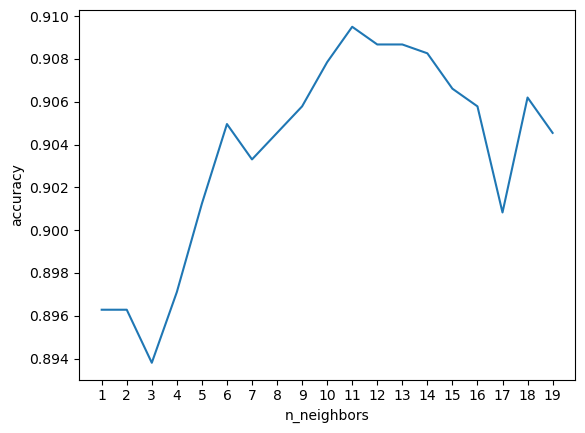

In [244]:
n_neighbors = range(1,20)
scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="cityblock", weights="distance")
    clf.fit(X_train_norm, y_train)
    scores.append(clf.score(X_test_norm, y_test))

plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

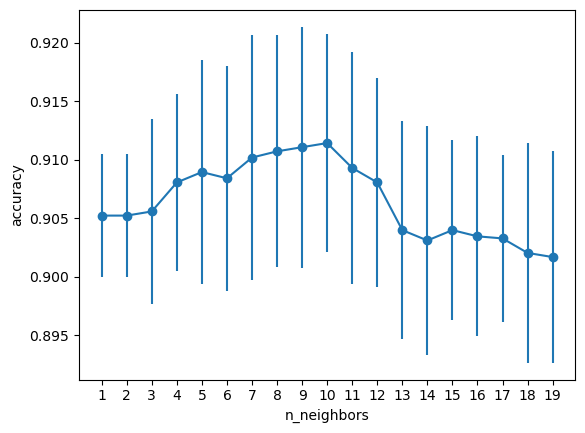

In [245]:
n_neighbors = range(1,20)
avg_scores = list()
std_scores = list()

for n in n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=n, metric="cityblock", weights="distance")
    scores = cross_val_score(clf, X_train_norm, y_train, cv=k)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

#plt.plot(avg_scores)
plt.errorbar(range(len(n_neighbors)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.show()

In [246]:
# clf = KNeighborsClassifier(n_neighbors=12, metric="euclidean", weights="uniform")
# clf.fit(X_train_norm, y_train)
# y_test_pred = clf.predict(X_test_norm)
# print("Accuracy:", accuracy_score(y_test, y_test_pred))

# Grid Search

In [247]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [248]:
param_grid = {
    "n_neighbors": np.arange(2, 15), 
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock"],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True, 
    # verbose=2
) 

grid.fit(X_train_norm, y_train)
clf = grid.best_estimator_

In [249]:
print(grid.best_params_, grid.best_score_)

{'metric': 'cityblock', 'n_neighbors': 6, 'weights': 'distance'} 0.904695958891632


# Learning curve

train_sizes = np.linspace(0.1, 1.0, 10)

Questa riga crea un array di dieci numeri che sono equamente spaziati tra 0.1 e 1.0. Questi numeri rappresenteranno le proporzioni del set di allenamento che verranno utilizzate per generare la curva di apprendimento. Ad esempio, se hai 1000 esempi di allenamento, il primo punto della curva di apprendimento userà il 10% di questi dati, cioè 100 esempi.

estimator=clf

Qui, stai assegnando il tuo modello k-NN, che hai chiamato clf nello screenshot precedente, alla variabile estimator. Questo modello verrà utilizzato dalla funzione learning_curve per allenare e testare il modello.

X = df.drop('genre', axis=1)
y = df['genre']

Queste due righe selezionano le features e il target dal tuo DataFrame. X contiene tutte le colonne tranne 'genre', che è la colonna del target che si presume tu voglia prevedere. y contiene i valori della colonna 'genre'.

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

Qui, crei un oggetto StandardScaler, che normalizza i dati delle features sottraendo la media e dividendo per la deviazione standard. Poi utilizzi questo oggetto per trasformare i tuoi dati in X_norm, che sono i dati delle features normalizzati.

train_sizes, train_scores, test_scores = learning_curve(...)

Questa funzione calcola la curva di apprendimento. Allena il tuo modello (clf) su diverse porzioni del set di dati (definite da train_sizes) e calcola i punteggi di accuratezza sul training set e sul test set. La cross-validation a 10 fold (cv=10) è utilizzata per valutare l'accuratezza del modello, che significa che i dati vengono divisi in 10 parti, con 9 utilizzate per l'allenamento e 1 per il test, e questo processo è ripetuto 10 volte con parti diverse utilizzate come test set.

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

Queste righe calcolano la media e la deviazione standard delle accuratezze ottenute durante la cross-validation sia per il training set sia per il test set. Ti permettono di vedere non solo come l'accuratezza cambia con diversi set di dati di allenamento, ma anche quanto sono variabili i risultati (indicati dalla deviazione standard).

Le ultime righe di codice (plt.figure(figsize=(10, 6)) fino a plt.show()) generano un grafico che mostra la curva di apprendimento. Mostrano l'accuratezza media sul training set e sul test set (anche chiamato validation set) in funzione della dimensione del training set, con le aree ombreggiate che rappresentano la deviazione standard. Il grafico è intitolato "Learning Curve for k-NN Classifier" e ha le etichette sugli assi appropriate per la dimensione dei dati di allenamento e l'accuratezza.

In [250]:
df_test= pd.read_csv("../../our_analyses/dataset_test_prepared.csv")

df_test=df_test.drop(['name', 'artists', 'album_name'], axis=1)
df_test['genre_group'] = df_test['genre'].map(genre_groups).astype(int)
df_test['explicit'] = le.transform(df_test['explicit'])

